In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import json
from PIL import Image
from collections import Counter
import pickle

In [2]:
base_path = '/home/rmahajani31/Projects/hubmap-hacking-the-human-vasculature'

In [3]:
def get_count_type(tiles_dict):
  ids_with_info = []
  for tile in tiles_dict:
    cur_dict = {'id': tile['id'], 'blood_vessel': 0, 'glomerulus': 0, 'unsure': 0}
    for annot in tile['annotations']:
      cur_dict[annot['type']] += 1
    ids_with_info.append(cur_dict)
  return ids_with_info

In [4]:
with open(f'{base_path}/polygons.jsonl', 'r') as json_file:
    json_list = list(json_file)
    
tiles_dicts = []
for json_str in json_list:
    tiles_dicts.append(json.loads(json_str))

In [5]:
tile_df = pd.read_csv(f'{base_path}/tile_meta.csv')
# Find the same stats as the above cell for annotated images
annotated_ids_with_info = get_count_type(tiles_dicts)
annotated_ids_with_info_df = pd.DataFrame.from_dict(annotated_ids_with_info)
tile_df_annotated = pd.merge(tile_df, annotated_ids_with_info_df, on='id', how='inner')
tile_df_annotated.head()

,id,source_wsi,dataset,i,j,blood_vessel,glomerulus,unsure
0,0006ff2aa7cd,2,2,16896,16420,8,1,0
1,00168d1b7522,2,2,14848,14884,1,1,0
2,0033bbc76b6b,1,1,10240,43008,3,0,1
3,003504460b3a,3,2,8192,11776,7,0,0
4,004daf1cbe75,3,2,6144,11264,10,1,0


In [6]:
dataset_1_tile_ids = sorted(tile_df_annotated.loc[tile_df_annotated['dataset']==1, 'id'].values)
# dataset_2_tile_ids = sorted(tile_df_annotated.loc[tile_df_annotated['dataset']==2, 'id'].values)

In [7]:
tgt_tile_dicts = [x for x in tiles_dicts if x['id'] in dataset_1_tile_ids]
print(len(tgt_tile_dicts))

422


In [8]:
tgt_tile_dicts[0]

{'id': '0033bbc76b6b',
 'annotations': [{'type': 'blood_vessel',
   'coordinates': [[[169, 228],
     [168, 228],
     [167, 228],
     [166, 228],
     [165, 228],
     [164, 228],
     [163, 228],
     [163, 227],
     [162, 227],
     [161, 227],
     [161, 226],
     [160, 226],
     [160, 225],
     [159, 225],
     [159, 224],
     [158, 224],
     [158, 223],
     [158, 222],
     [158, 221],
     [158, 220],
     [157, 220],
     [157, 219],
     [157, 218],
     [157, 217],
     [156, 217],
     [156, 216],
     [156, 215],
     [156, 214],
     [156, 213],
     [155, 213],
     [155, 212],
     [154, 212],
     [154, 211],
     [153, 211],
     [153, 210],
     [153, 209],
     [152, 209],
     [152, 208],
     [152, 207],
     [151, 207],
     [150, 207],
     [150, 206],
     [149, 206],
     [149, 205],
     [148, 205],
     [148, 204],
     [148, 203],
     [147, 203],
     [147, 202],
     [147, 201],
     [147, 200],
     [146, 200],
     [146, 199],
     [146, 198],
  

In [37]:
if not os.path.exists(f'{base_path}/dataset1_files/all_dataset1_annotations'):
  os.mkdir(f'{base_path}/dataset1_files/all_dataset1_annotations')

In [38]:
def calculate_area(coordinates):
    num_points = len(coordinates)
    if num_points < 3:
        return 0

    area = 0
    for i in range(num_points - 1):
        x_i, y_i = coordinates[i]
        x_iplus1, y_iplus1 = coordinates[i + 1]
        area += (x_i * y_iplus1) - (x_iplus1 * y_i)

    x_n, y_n = coordinates[-1]
    x_0, y_0 = coordinates[0]
    area += (x_n * y_0) - (x_0 * y_n)

    area = abs(area / 2)
    return area

In [39]:
for tgt_tile_dict in tgt_tile_dicts:
  cur_tile_coco_annots = []
  img_id = tgt_tile_dict['id']
  annotations = [annot for annot in tgt_tile_dict['annotations'] if annot['type']=='blood_vessel']
  for annot in annotations:
    coords = annot['coordinates'][0]
    segmentations = [[pt for pair in coords for pt in pair]]
    segmentation_area = calculate_area(coords)
    min_x = min(coords, key=lambda x: x[0])[0]
    max_x = max(coords, key=lambda x: x[0])[0]
    min_y = min(coords, key=lambda x: x[1])[1]
    max_y = max(coords, key=lambda x: x[1])[1]
    segmentation_bbox = [min_x, min_y, max_x-min_x, max_y-min_y]
    category_id = 0
    cur_tile_coco_annots.append({
      'segmentation': segmentations,
      'area': segmentation_area,
      'bbox': segmentation_bbox,
      'category_id': category_id
    })
  with open(f'{base_path}/dataset1_files/all_dataset1_annotations/{img_id}.pkl', 'wb') as f:
    pickle.dump(cur_tile_coco_annots, f, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
img_annot_files = os.listdir(f'{base_path}/dataset1_files/all_dataset1_annotations')
img_annot_files[:5]

['e0072029e135.pkl',
 '5de1d0bea7fe.pkl',
 '4b71f2e1d1ba.pkl',
 '88d349bebe86.pkl',
 '4eef9950c417.pkl']

In [16]:
import random
img_annot_file = random.choice(img_annot_files)

In [17]:
img_annot_file

'ef7f5d12b1ff.pkl'

In [23]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

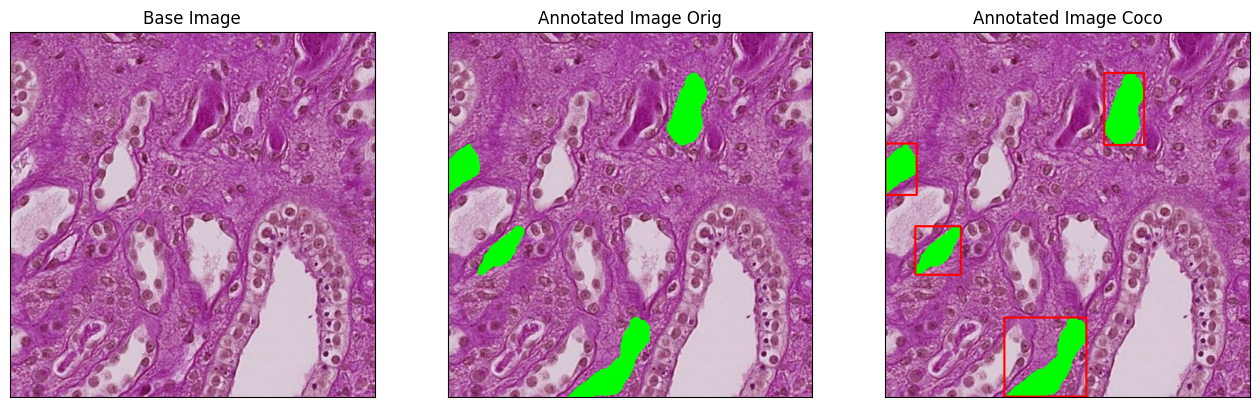

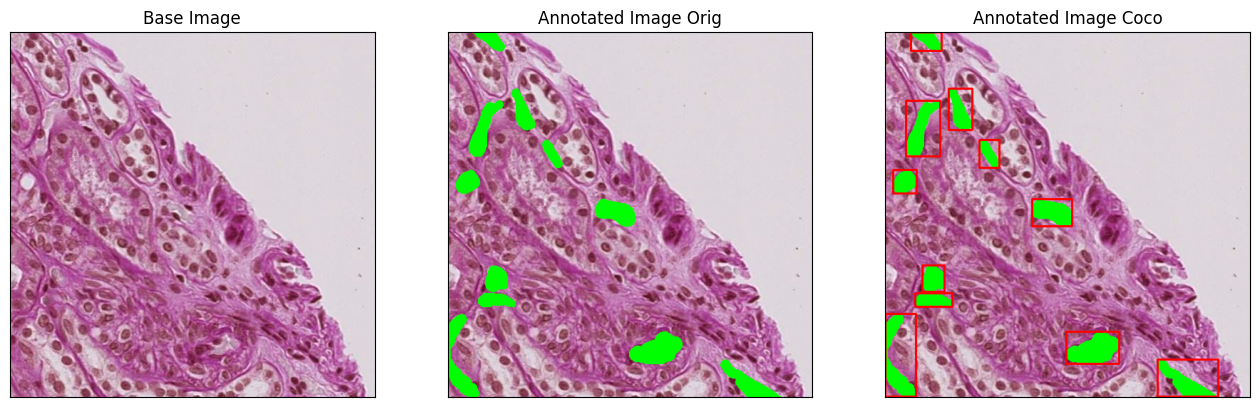

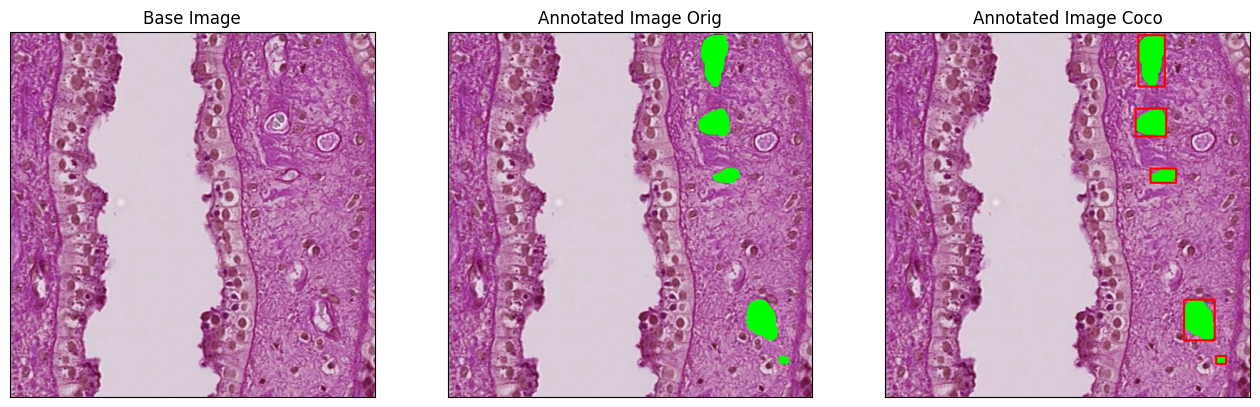

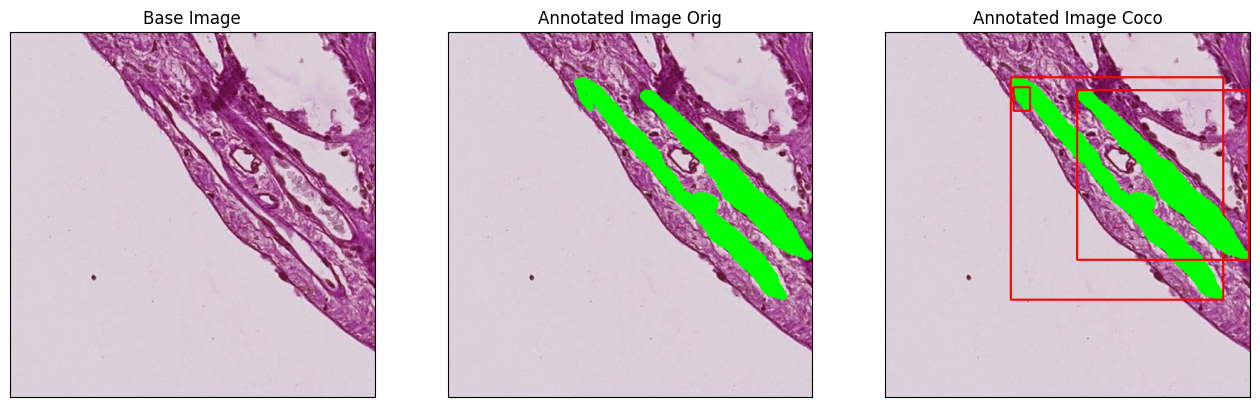

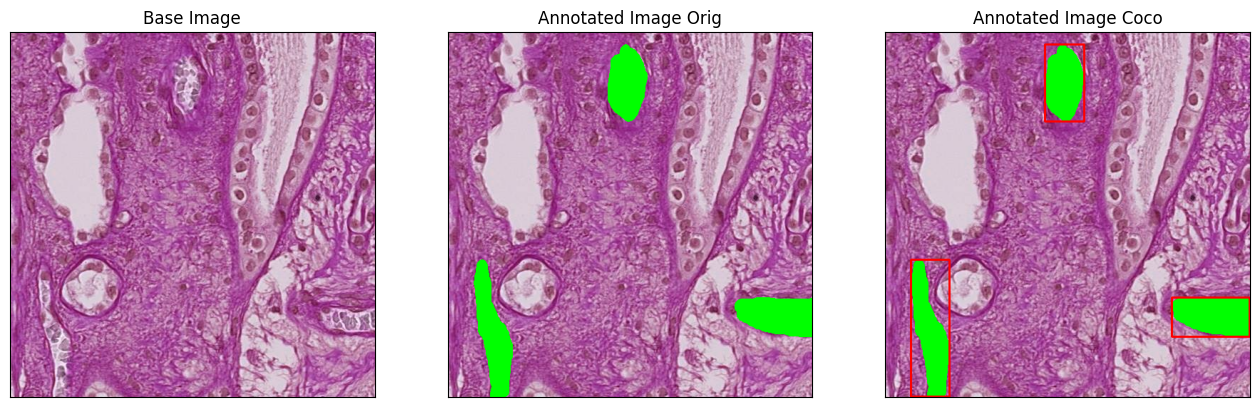

In [29]:
import copy
for i in range(5):
  img_annot_file = random.choice(img_annot_files)
  img_id = img_annot_file.split('.')[0]
  with open(f'{base_path}/dataset1_files/all_dataset1_annotations/{img_annot_file}', 'rb') as f:
    tgt_annots = pickle.load(f)
  # print(tgt_annots)
  base_image = cv2.imread(f'{base_path}/dataset1_files/all_dataset1_imgs/{img_id}.png')
  base_image = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)
  annotated_image_orig = copy.deepcopy(base_image)
  annotated_image_coco = copy.deepcopy(base_image)
  imgs_dict = dict()
  imgs_dict['base_image'] = base_image
  for tgt_annot in tgt_annots:
    coords = [[x, y] for x, y in zip(tgt_annot['segmentation'][0][::2], tgt_annot['segmentation'][0][1::2])]
    min_x, min_y, width, height = tgt_annot['bbox']
    cv2.fillPoly(annotated_image_coco, pts=[np.array(coords)], color=(0,255,0))
    top_left = (int(tgt_annot['bbox'][0]), int(tgt_annot['bbox'][1]))
    min_x = min(coords, key=lambda x: x[0])[0]
    min_y = min(coords, key=lambda x: x[1])[1]
    max_x = max(coords, key=lambda x: x[0])[0]
    max_y = max(coords, key=lambda x: x[1])[1]
    bottom_right = (int(tgt_annot['bbox'][0]+tgt_annot['bbox'][2]), int(tgt_annot['bbox'][1]+tgt_annot['bbox'][3]))
    annotated_image_coco = cv2.rectangle(annotated_image_coco, top_left, bottom_right, (255,0,0), 2)

  tgt_orig_annots = [annot for annot in [x for x in tgt_tile_dicts if x['id']==img_id][0]['annotations'] if annot['type']=='blood_vessel']
  for tgt_orig_annot in tgt_orig_annots:
    coords = tgt_orig_annot['coordinates']
    cv2.fillPoly(annotated_image_orig, pts=[np.array(coords)], color=(0,255,0))
  imgs_dict['annotated_image_orig'] = annotated_image_orig
  imgs_dict['annotated_image_coco'] = annotated_image_coco
  visualize(**imgs_dict)